In [ ]:
! pip install --no-deps autoxgb
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
!pip install optuna
!pip install catboost
from catboost import CatBoostClassifier
from autoxgb import AutoXGB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
import geopandas as gpd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=1e05a170ef4d8b32110bc1ea22e07125920a24f88bd787d0e9e025d6b84e5cd3
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoxgb 0.2.2 requires fastapi==0.70.0, which is not installed.
autoxgb 0.2.2 requires loguru==0.5.3, which is not installed.
autoxgb 0.2.2 requires uvicorn==0.15.0, which is 

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c school-of-quants-hack-23-final
! unzip -qq school-of-quants-hack-23-final.zip

Saving kaggle.json to kaggle.json
 98% 367M/376M [00:01<00:00, 255MB/s]
100% 376M/376M [00:01<00:00, 229MB/s]


Обозначу все функции здесь

In [ ]:
def preprocessing(train, enc):
  for col in train.columns:
    if train[col].dtype == 'float64':
       train[col] = train[col].astype(np.float16)
    elif train[col].dtype == 'int64':
        train[col] = train[col].astype(np.int16)

  # train['result'] = train['result'].astype(np.int8)

  obj_name = [x for x in train.columns if train_[x].dtype == 'object']

  for col in obj_name:
    train[col] = enc.transform(train[col])

  for col in obj_name:
    train[col] = train[col].astype(np.int8)

  return train

def cross_validate(model, X, y, split = 3):
   skf = StratifiedKFold(n_splits=split)
   models = []
   scores = []
   for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        score = f1_score(model.predict(X_val), y_val, average = 'micro')
        scores.append(score)
        models.append(model)
        print(score)
   print(np.mean(scores), np.std(scores))
   return models

def pred_cross(models, X):
  preds = [mode.predict(X) for mode in models]
  res = []
  for i in range(len(preds[0])):
     pr = [pred[i] for pred in preds]
     res.append(int(stats.mode(pr)[0][0]))
  return res

def pred_proba(models, X):
  res = [model.predict_proba(X) for model in models]
  return np.sum(res, axis=0)

def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X, y, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels, average = 'micro')
    return f1

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head(10)

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2,atr,resist1,ema_rel,support1,ichi_base,exch,resist2,ichi_b,macd_hist_rel
0,Hold,3.135142e-04,32.11,5.115713,-9.398346e-05,-24.93,Sell,0,41.644171,0.005576,...,-10.67,0.002527,9.50,1.026437,-4.76,2.722192,BC,17.85,5.110871,-1.027237
1,Sell,0.000000e+00,5.60,85.714286,1.585063e-06,-6.44,Buy,1,113.015873,0.017626,...,-3.43,0.000207,1.37,0.995089,-1.64,-1.103310,BB,2.59,-0.451354,-0.993209
2,Hold,0.000000e+00,1.30,50.000000,0.000000e+00,-1.30,Sell,1,46.666667,0.002156,...,-0.65,0.000005,0.28,1.000046,-0.37,-0.061000,BB,0.65,-0.020333,-0.999840
3,Hold,-8.791675e-05,2.30,71.428571,-3.290121e-07,-2.27,Sell,1,114.920635,0.004187,...,-1.13,0.002067,0.60,0.999847,-0.54,-0.204248,BC,1.16,-0.040850,-0.999806
4,Buy,-3.337844e-06,1.37,9.090909,-3.157212e-07,-1.03,Sell,1,37.272727,0.000846,...,-0.43,0.000187,0.45,1.000930,-0.15,0.168413,OK,0.77,0.168413,-1.001124
5,Hold,-4.670043e-07,26.19,18.518519,8.090406e-08,-35.11,Sell,1,48.319745,0.041851,...,-19.78,0.000091,-0.08,1.001646,-15.40,0.753111,BB,10.87,-6.974460,-1.002422
6,Hold,8.296672e-07,3.67,77.500000,-1.352145e-07,-3.44,Sell,1,116.012266,0.006839,...,-1.66,0.000987,1.21,0.999231,-0.57,-0.349783,OK,1.89,0.406504,-0.998227
7,Hold,-1.949219e-06,0.55,61.111111,5.358238e-06,-0.84,Buy,1,88.359751,0.001617,...,-0.49,0.000085,0.02,0.999871,-0.33,-0.096342,OK,0.20,-0.142290,-0.999576
8,Hold,-3.442082e-04,2.30,91.666667,9.068477e-06,-2.69,Buy,1,126.444444,0.004664,...,-1.44,0.002667,0.49,0.999083,-0.76,-0.207900,BC,1.06,-0.187110,-0.999324
9,Hold,-8.746794e-05,3.15,0.000000,-1.137222e-04,-2.59,Sell,1,42.370370,0.002732,...,-1.15,0.007333,0.81,1.001865,-0.63,0.270479,BC,1.72,0.551998,-1.001881


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366032 entries, 0 to 1366031
Data columns (total 39 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   rsi_sig        1366032 non-null  object 
 1   vwap_short     1366032 non-null  float64
 2   resist3        1366032 non-null  float64
 3   stoch_k        1366032 non-null  float64
 4   vwap_long      1366032 non-null  float64
 5   support3       1366032 non-null  float64
 6   fibo_sig       1366032 non-null  object 
 7   result         1366032 non-null  int64  
 8   stoch_k_sm     1366032 non-null  float64
 9   boll_up        1366032 non-null  float64
 10  stoch_d        1366032 non-null  float64
 11  ichi_sig       1366032 non-null  object 
 12  boll_low       1366032 non-null  float64
 13  stoch_sig      1366032 non-null  object 
 14  macd_rel       1366032 non-null  float64
 15  pivot_pt       1366032 non-null  float64
 16  macd_sig_rel   1366032 non-null  float64
 17  wma_rel 

In [ ]:
pd.to_pickle(train, 'train_.pickle')

In [ ]:
train_ = pd.read_pickle('train_.pickle')

In [ ]:
for col in train_.columns:
  if train_[col].dtype == 'float64':
     train_[col] = train_[col].astype(np.float16)
  elif train_[col].dtype == 'int64':
      train_[col] = train_[col].astype(np.int16)

In [ ]:
train_.isnull().sum()

rsi_sig          0
vwap_short       0
resist3          0
stoch_k          0
vwap_long        0
support3         0
fibo_sig         0
result           0
stoch_k_sm       0
boll_up          0
stoch_d          0
ichi_sig         0
boll_low         0
stoch_sig        0
macd_rel         0
pivot_pt         0
macd_sig_rel     0
wma_rel          0
stoch_sig_val    0
s&p500           0
ichi_a           0
boll_sig         0
adx              0
ichi_conv        0
ma_rel           0
sma_rel          0
rsi              0
sar_rel          0
macd             0
support2         0
atr              0
resist1          0
ema_rel          0
support1         0
ichi_base        0
exch             0
resist2          0
ichi_b           0
macd_hist_rel    0
dtype: int64

In [ ]:
train_['result'] = train_['result'].astype(np.int8)

In [ ]:
train_.head(10)

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2,atr,resist1,ema_rel,support1,ichi_base,exch,resist2,ichi_b,macd_hist_rel
0,Hold,3.135204e-04,32.125000,5.117188,-9.399652e-05,-24.937500,Sell,0,41.65625,0.005577,...,-10.671875,0.002527,9.500000,1.026367,-4.761719,2.722656,BC,17.843750,5.109375,-1.027344
1,Sell,0.000000e+00,5.601562,85.687500,1.609325e-06,-6.441406,Buy,1,113.00000,0.017624,...,-3.429688,0.000207,1.370117,0.995117,-1.639648,-1.103516,BB,2.589844,-0.451416,-0.993164
2,Hold,0.000000e+00,1.299805,50.000000,0.000000e+00,-1.299805,Sell,1,46.65625,0.002155,...,-0.649902,0.000005,0.280029,1.000000,-0.370117,-0.061005,BB,0.649902,-0.020340,-1.000000
3,Hold,-8.791685e-05,2.300781,71.437500,-3.576279e-07,-2.269531,Sell,1,114.93750,0.004189,...,-1.129883,0.002068,0.600098,1.000000,-0.540039,-0.204224,BC,1.160156,-0.040863,-1.000000
4,Buy,-3.337860e-06,1.370117,9.093750,-2.980232e-07,-1.030273,Sell,1,37.28125,0.000846,...,-0.429932,0.000187,0.449951,1.000977,-0.150024,0.168457,OK,0.770020,0.168457,-1.000977
5,Hold,-4.768372e-07,26.187500,18.515625,5.960464e-08,-35.125000,Sell,1,48.31250,0.041840,...,-19.781250,0.000091,-0.080017,1.001953,-15.398438,0.752930,BB,10.867188,-6.972656,-1.001953
6,Hold,8.344650e-07,3.669922,77.500000,-1.192093e-07,-3.439453,Sell,1,116.00000,0.006840,...,-1.660156,0.000987,1.209961,0.999023,-0.569824,-0.349854,OK,1.889648,0.406494,-0.998047
7,Hold,-1.966953e-06,0.549805,61.125000,5.364418e-06,-0.839844,Buy,1,88.37500,0.001616,...,-0.489990,0.000085,0.020004,1.000000,-0.330078,-0.096313,OK,0.199951,-0.142334,-0.999512
8,Hold,-3.442764e-04,2.300781,91.687500,9.059906e-06,-2.689453,Buy,1,126.43750,0.004665,...,-1.440430,0.002666,0.489990,0.999023,-0.759766,-0.207886,BC,1.059570,-0.187134,-0.999512
9,Hold,-8.744001e-05,3.150391,0.000000,-1.137257e-04,-2.589844,Sell,1,42.37500,0.002731,...,-1.150391,0.007332,0.810059,1.001953,-0.629883,0.270508,BC,1.719727,0.551758,-1.001953


In [ ]:
obj_name = [x for x in train_.columns if train_[x].dtype == 'object']

In [ ]:
train_[obj_name]

,rsi_sig,fibo_sig,ichi_sig,stoch_sig,boll_sig,exch
0,Hold,Sell,Sell,Sell,Hold,BC
1,Sell,Buy,Sell,Sell,Hold,BB
2,Hold,Sell,Sell,Buy,Hold,BB
3,Hold,Sell,Buy,Sell,Hold,BC
4,Buy,Sell,Buy,Sell,Hold,OK
...,...,...,...,...,...,...
1366027,Hold,Buy,Sell,Sell,Hold,OK
1366028,Hold,Sell,Sell,Sell,Hold,BC
1366029,Hold,Buy,Buy,Sell,Hold,OK
1366030,Hold,Buy,Sell,Sell,Hold,HB


In [ ]:
train_[obj_name].nunique()

rsi_sig      3
fibo_sig     3
ichi_sig     3
stoch_sig    3
boll_sig     3
exch         4
dtype: int64

In [ ]:
enc = OrdinalEncoder()

In [ ]:
enc.fit(train_[obj_name])

OrdinalEncoder()

In [ ]:
train_[obj_name]= enc.transform(train_[obj_name])

In [ ]:
train_

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2,atr,resist1,ema_rel,support1,ichi_base,exch,resist2,ichi_b,macd_hist_rel
0,1.0,0.000314,32.125000,5.117188,-9.399652e-05,-24.937500,2.0,0,41.65625,0.005577,...,-10.671875,2.527237e-03,9.500000,1.026367,-4.761719,2.722656,1.0,17.843750,5.109375,-1.027344
1,2.0,0.000000,5.601562,85.687500,1.609325e-06,-6.441406,0.0,1,113.00000,0.017624,...,-3.429688,2.067089e-04,1.370117,0.995117,-1.639648,-1.103516,0.0,2.589844,-0.451416,-0.993164
2,1.0,0.000000,1.299805,50.000000,0.000000e+00,-1.299805,2.0,1,46.65625,0.002155,...,-0.649902,5.304813e-06,0.280029,1.000000,-0.370117,-0.061005,0.0,0.649902,-0.020340,-1.000000
3,1.0,-0.000088,2.300781,71.437500,-3.576279e-07,-2.269531,2.0,1,114.93750,0.004189,...,-1.129883,2.067566e-03,0.600098,1.000000,-0.540039,-0.204224,1.0,1.160156,-0.040863,-1.000000
4,0.0,-0.000003,1.370117,9.093750,-2.980232e-07,-1.030273,2.0,1,37.28125,0.000846,...,-0.429932,1.866817e-04,0.449951,1.000977,-0.150024,0.168457,3.0,0.770020,0.168457,-1.000977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366027,1.0,-0.000001,6.460938,53.718750,-1.072884e-06,-4.390625,0.0,1,82.31250,0.004509,...,-1.679688,1.040101e-04,2.800781,1.000977,0.090027,0.012550,3.0,3.750000,1.418945,-1.001953
1366028,1.0,-0.000097,7.218750,11.109375,-1.794100e-05,-6.070312,2.0,1,48.50000,0.005367,...,-2.750000,4.798889e-03,1.860352,1.001953,-1.459961,0.051117,1.0,3.900391,1.379883,-1.000977
1366029,1.0,-0.009666,4.601562,24.078125,7.730722e-05,-4.890625,0.0,0,56.12500,0.007149,...,-2.519531,1.912842e-01,1.179688,1.000000,-1.190430,-0.129883,3.0,2.230469,-0.121521,-1.000000
1366030,1.0,0.000031,5.988281,87.500000,3.039837e-06,-5.609375,0.0,1,99.93750,0.009995,...,-2.710938,1.099586e-03,1.820312,0.998535,-1.080078,-0.524902,2.0,3.089844,0.613281,-0.998047


In [ ]:
train_[obj_name]

,rsi_sig,fibo_sig,ichi_sig,stoch_sig,boll_sig,exch
0,1.0,2.0,2.0,2.0,1.0,1.0
1,2.0,0.0,2.0,2.0,1.0,0.0
2,1.0,2.0,2.0,0.0,1.0,0.0
3,1.0,2.0,0.0,2.0,1.0,1.0
4,0.0,2.0,0.0,2.0,1.0,3.0
...,...,...,...,...,...,...
1366027,1.0,0.0,2.0,2.0,1.0,3.0
1366028,1.0,2.0,2.0,2.0,1.0,1.0
1366029,1.0,0.0,0.0,2.0,1.0,3.0
1366030,1.0,0.0,2.0,2.0,1.0,2.0


In [ ]:
train_.head(10)

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2,atr,resist1,ema_rel,support1,ichi_base,exch,resist2,ichi_b,macd_hist_rel
0,1,3.135204e-04,32.125000,5.117188,-9.399652e-05,-24.937500,2,0,41.65625,0.005577,...,-10.671875,0.002527,9.500000,1.026367,-4.761719,2.722656,1,17.843750,5.109375,-1.027344
1,2,0.000000e+00,5.601562,85.687500,1.609325e-06,-6.441406,0,1,113.00000,0.017624,...,-3.429688,0.000207,1.370117,0.995117,-1.639648,-1.103516,0,2.589844,-0.451416,-0.993164
2,1,0.000000e+00,1.299805,50.000000,0.000000e+00,-1.299805,2,1,46.65625,0.002155,...,-0.649902,0.000005,0.280029,1.000000,-0.370117,-0.061005,0,0.649902,-0.020340,-1.000000
3,1,-8.791685e-05,2.300781,71.437500,-3.576279e-07,-2.269531,2,1,114.93750,0.004189,...,-1.129883,0.002068,0.600098,1.000000,-0.540039,-0.204224,1,1.160156,-0.040863,-1.000000
4,0,-3.337860e-06,1.370117,9.093750,-2.980232e-07,-1.030273,2,1,37.28125,0.000846,...,-0.429932,0.000187,0.449951,1.000977,-0.150024,0.168457,3,0.770020,0.168457,-1.000977
5,1,-4.768372e-07,26.187500,18.515625,5.960464e-08,-35.125000,2,1,48.31250,0.041840,...,-19.781250,0.000091,-0.080017,1.001953,-15.398438,0.752930,0,10.867188,-6.972656,-1.001953
6,1,8.344650e-07,3.669922,77.500000,-1.192093e-07,-3.439453,2,1,116.00000,0.006840,...,-1.660156,0.000987,1.209961,0.999023,-0.569824,-0.349854,3,1.889648,0.406494,-0.998047
7,1,-1.966953e-06,0.549805,61.125000,5.364418e-06,-0.839844,0,1,88.37500,0.001616,...,-0.489990,0.000085,0.020004,1.000000,-0.330078,-0.096313,3,0.199951,-0.142334,-0.999512
8,1,-3.442764e-04,2.300781,91.687500,9.059906e-06,-2.689453,0,1,126.43750,0.004665,...,-1.440430,0.002666,0.489990,0.999023,-0.759766,-0.207886,1,1.059570,-0.187134,-0.999512
9,1,-8.744001e-05,3.150391,0.000000,-1.137257e-04,-2.589844,2,1,42.37500,0.002731,...,-1.150391,0.007332,0.810059,1.001953,-0.629883,0.270508,1,1.719727,0.551758,-1.001953


In [ ]:
for col in obj_name:
    train_[col] = train_[col].astype(np.int8)

In [ ]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366032 entries, 0 to 1366031
Data columns (total 39 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   rsi_sig        1366032 non-null  int8   
 1   vwap_short     1366032 non-null  float16
 2   resist3        1366032 non-null  float16
 3   stoch_k        1366032 non-null  float16
 4   vwap_long      1366032 non-null  float16
 5   support3       1366032 non-null  float16
 6   fibo_sig       1366032 non-null  int8   
 7   result         1366032 non-null  int8   
 8   stoch_k_sm     1366032 non-null  float16
 9   boll_up        1366032 non-null  float16
 10  stoch_d        1366032 non-null  float16
 11  ichi_sig       1366032 non-null  int8   
 12  boll_low       1366032 non-null  float16
 13  stoch_sig      1366032 non-null  int8   
 14  macd_rel       1366032 non-null  float16
 15  pivot_pt       1366032 non-null  float16
 16  macd_sig_rel   1366032 non-null  float16
 17  wma_rel 

In [ ]:
X = train_.drop('result', axis = 1)
y = train_['result']

In [ ]:
model = CatBoostClassifier()

In [ ]:
model.fit(X, y, verbose = 0)

In [ ]:
f1_score(model.predict(X), y, average = 'micro')

0.9411741452616044

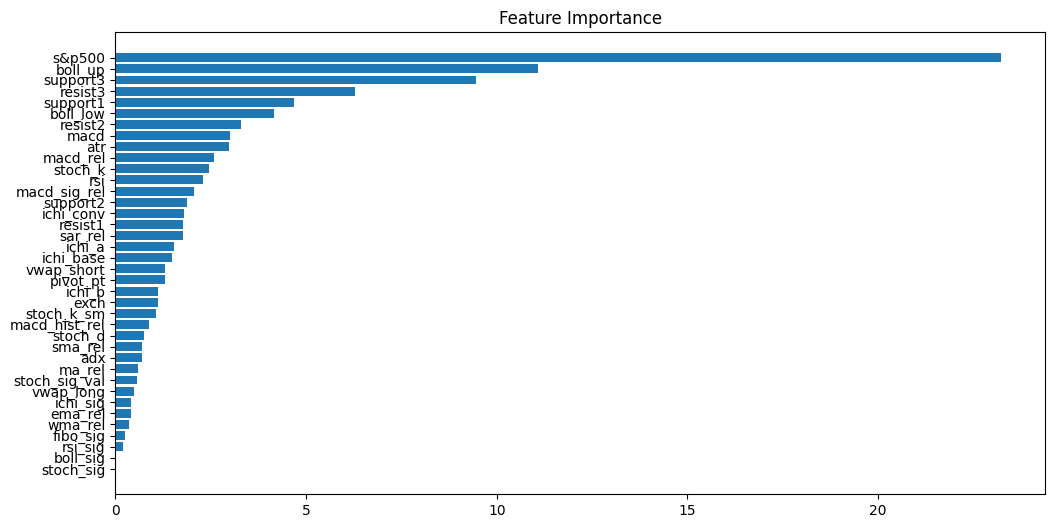

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [ ]:
dict_import = {}
for name, coef in zip(X.columns, feature_importance):
    dict_import[name] = coef

In [ ]:
dict_import

{'rsi_sig': 0.20810338232133435,
 'vwap_short': 1.3083010710736962,
 'resist3': 6.293449908419563,
 'stoch_k': 2.4643762259141324,
 'vwap_long': 0.47983960501722733,
 'support3': 9.45038297186511,
 'fibo_sig': 0.2453872891257816,
 'stoch_k_sm': 1.051292639302652,
 'boll_up': 11.068555165935514,
 'stoch_d': 0.7494233208819634,
 'ichi_sig': 0.4129179286065064,
 'boll_low': 4.161618702608721,
 'stoch_sig': 0.004388255035803943,
 'macd_rel': 2.591214526764,
 'pivot_pt': 1.305089678045356,
 'macd_sig_rel': 2.0611473640496483,
 'wma_rel': 0.3595909008217805,
 'stoch_sig_val': 0.5748618367237587,
 's&p500': 23.22781843476495,
 'ichi_a': 1.5256332399117845,
 'boll_sig': 0.022704388672477795,
 'adx': 0.6898972675536279,
 'ichi_conv': 1.806973587593364,
 'ma_rel': 0.5834884388247585,
 'sma_rel': 0.7065922270153443,
 'rsi': 2.283321873115579,
 'sar_rel': 1.76173451343903,
 'macd': 3.0040363358261675,
 'support2': 1.8776406012705642,
 'atr': 2.9697787793327657,
 'resist1': 1.767511960940848,
 'ema

In [ ]:
low_label = dict_import['macd_hist_rel']

In [ ]:
features = []
for name in X.columns:
    if dict_import[name] < low_label:
        features.append(name)

In [ ]:
X = X.drop(features, axis = 1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366032 entries, 0 to 1366031
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   vwap_short     1366032 non-null  float16
 1   resist3        1366032 non-null  float16
 2   stoch_k        1366032 non-null  float16
 3   support3       1366032 non-null  float16
 4   stoch_k_sm     1366032 non-null  float16
 5   boll_up        1366032 non-null  float16
 6   boll_low       1366032 non-null  float16
 7   macd_rel       1366032 non-null  float16
 8   pivot_pt       1366032 non-null  float16
 9   macd_sig_rel   1366032 non-null  float16
 10  s&p500         1366032 non-null  float16
 11  ichi_a         1366032 non-null  float16
 12  ichi_conv      1366032 non-null  float16
 13  rsi            1366032 non-null  float16
 14  sar_rel        1366032 non-null  float16
 15  macd           1366032 non-null  float16
 16  support2       1366032 non-null  float16
 17  atr     

In [ ]:
model.fit(X, y, verbose = 0)

In [ ]:
f1_score(model.predict(X), y, average = 'micro')

0.9408498483198051

In [ ]:
test = preprocessing(test, enc)

In [ ]:
test[obj_name] = enc.transform(test[obj_name])

In [ ]:
for col in obj_name:
    test[col] = test[col].astype(np.int8)

In [ ]:
features = []
for name in dict_import.keys():
    if dict_import[name] < low_label:
        features.append(name)

In [ ]:
len(features)

13

In [ ]:
test = test.drop(features, axis = 1)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341166 entries, 0 to 341165
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   vwap_short     341166 non-null  float16
 1   resist3        341166 non-null  float16
 2   stoch_k        341166 non-null  float16
 3   support3       341166 non-null  float16
 4   result         341166 non-null  int8   
 5   stoch_k_sm     341166 non-null  float16
 6   boll_up        341166 non-null  float16
 7   boll_low       341166 non-null  float16
 8   macd_rel       341166 non-null  float16
 9   pivot_pt       341166 non-null  float16
 10  macd_sig_rel   341166 non-null  float16
 11  s&p500         341166 non-null  float16
 12  ichi_a         341166 non-null  float16
 13  ichi_conv      341166 non-null  float16
 14  rsi            341166 non-null  float16
 15  sar_rel        341166 non-null  float16
 16  macd           341166 non-null  float16
 17  support2       341166 non-nul

In [ ]:
y_test = test['result']
X_test = test.drop('result', axis = 1)

In [ ]:
f1_score(model.predict(X_test), y_test, average = 'micro')

0.9336803784667874

In [ ]:
train_new = pd.concat([train, train_1], axis = 0)
train_new['result'] = train_new['result'].astype('category')
train = pd.concat([X, y], axis = 1)
train_1 = pd.concat([X_test, y_test], axis = 1)
train = pd.concat([X, y], axis = 1)
train_1 = pd.concat([X_test, y_test], axis = 1)

In [ ]:
cat = cross_validate(CatBoostClassifier(), X, y)
pred = pred_cross(cat, X_test)
f1_score(pred, y_test, average = 'micro')

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

In [ ]:
cat = cross_validate(CatBoostClassifier(study.best_trial.params), X, y)
pred = pred_cross(cat, X_test)
f1_score(pred, y_test, average = 'micro')

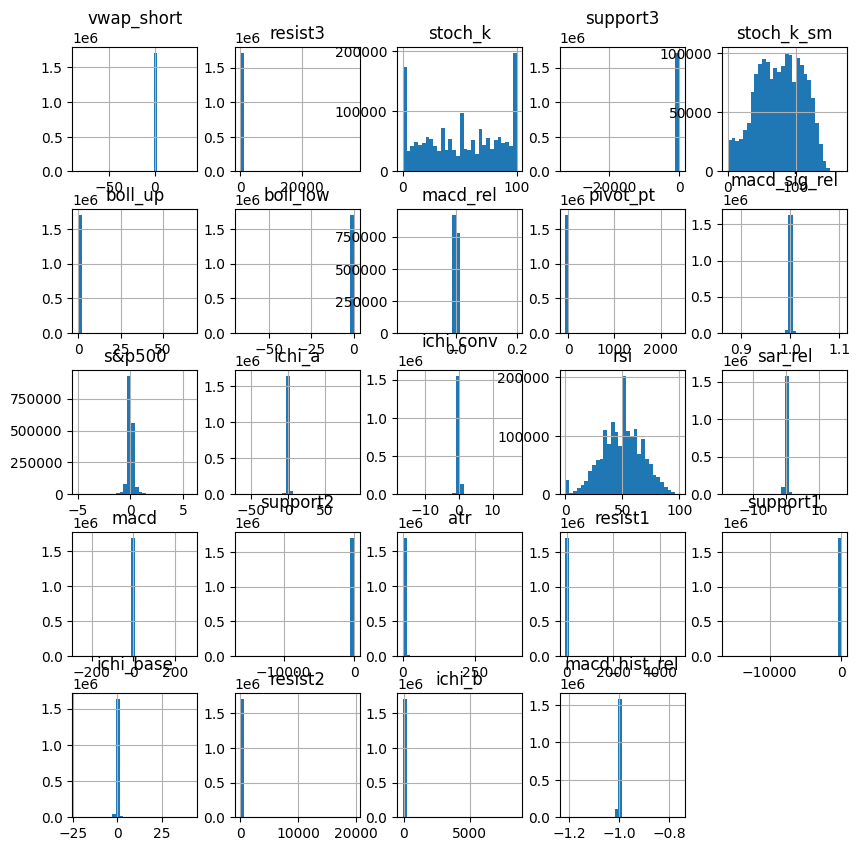

In [ ]:
import seaborn as sns
train_new.select_dtypes(include=['int16', 'float16']).hist(bins=30, figsize=(10, 10))
plt.show()

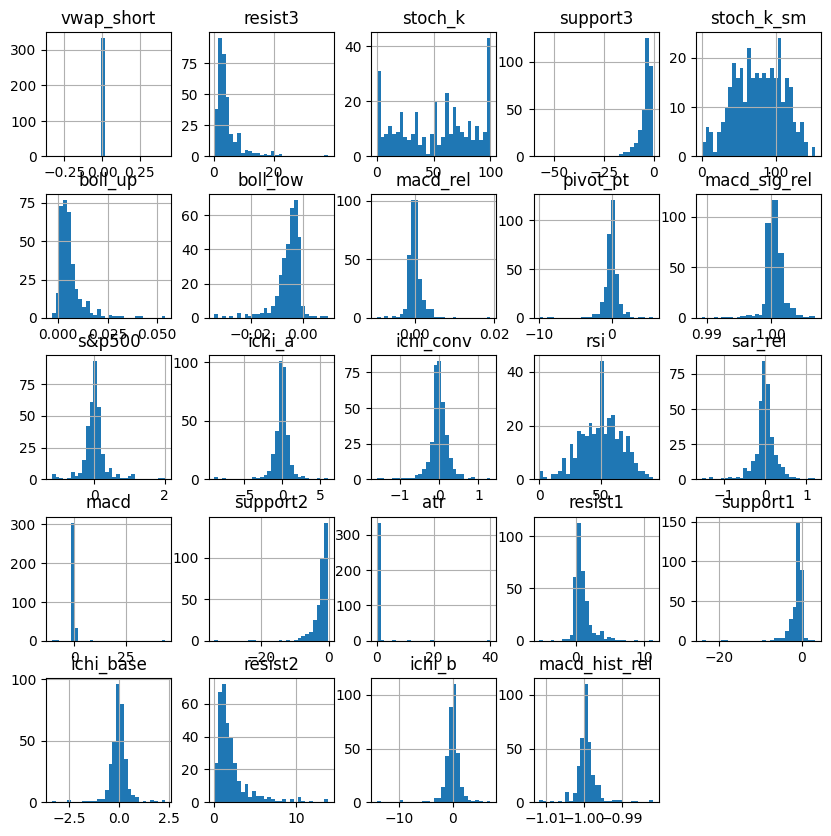

In [ ]:
test.select_dtypes(include=['int16', 'float16']).hist(bins=30, figsize=(10, 10))
plt.savefig('solution.png')
plt.show()

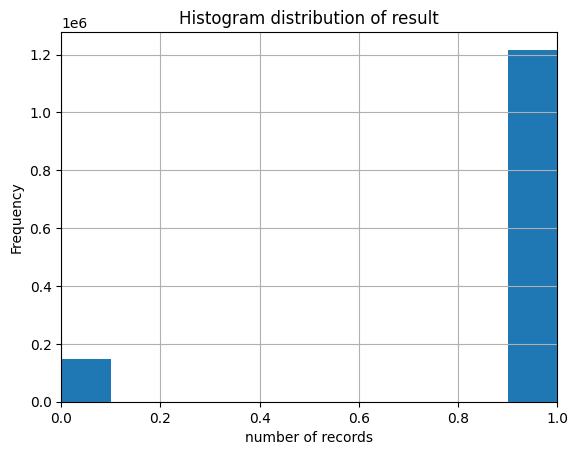

In [ ]:
plt.grid(True)
plt.title('Histogram distribution of result')
plt.ylabel('Frequency')
plt.xlabel('number of records')
plt.xlim(0,1)
plt.hist(y)
plt.show()

In [ ]:
train_filename="train.csv"
output="sub"
test_filename="test.csv"
idx="Id"
targets=["result"]
use_gpu=True
num_folds=5
seed=42
num_trials=50
time_limit=3600
categorical_features = ['result']

In [ ]:
axgb=AutoXGB(
    train_filename=train_filename,
    output=output,
    test_filename=test_filename,
    idx=idx,
    targets=targets,
    use_gpu=use_gpu,
    num_folds=num_folds,
    num_trials=num_trials,
    time_limit=time_limit
)

2023-09-12 21:46:04,645 INFO Output directory: sub
INFO:autoxgb:Output directory: sub


In [ ]:
axgb.train()

2023-09-12 21:46:06,618 INFO Reading training data
INFO:autoxgb:Reading training data
2023-09-12 21:46:18,633 INFO Mem. usage decreased to 87.92 Mb (75.0% reduction)
INFO:autoxgb:Mem. usage decreased to 87.92 Mb (75.0% reduction)
2023-09-12 21:46:18,721 INFO Problem type: binary_classification
INFO:autoxgb:Problem type: binary_classification
2023-09-12 21:46:18,748 INFO Mem. usage decreased to 0.02 Mb (75.3% reduction)
INFO:autoxgb:Mem. usage decreased to 0.02 Mb (75.3% reduction)
2023-09-12 21:46:18,752 INFO Creating folds
INFO:autoxgb:Creating folds
2023-09-12 21:46:19,119 INFO Encoding target(s)
INFO:autoxgb:Encoding target(s)
2023-09-12 21:46:19,206 INFO Found 0 categorical features.
INFO:autoxgb:Found 0 categorical features.
2023-09-12 21:46:23,426 INFO Model config: train_filename='train.csv' test_filename='test.csv' idx='Id' targets=['result'] problem_type=<ProblemType.binary_classification: 1> output='sub' features=['Unnamed: 0', 'vwap_short', 'resist3', 'stoch_k', 'support3', 

In [ ]:
h2o.init(max_mem_size='10G')
train = h2o.import_file("train.csv")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 mins 12 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,"21 days, 21 hours and 28 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_mjc191
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,9.56 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
test = h2o.import_file("solut.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
x = train.columns
y = 'result'
x.remove(y)

In [ ]:
aml = H2OAutoML(seed = 1, project_name = "submit", nfolds = 3, max_runtime_secs = 5400)

In [ ]:
h2o.estimators.xgboost.H2OXGBoostEstimator.available()

True

In [ ]:
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |
13:45:45.590: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.590: _stopping_metric param, Stopping metric cannot be AUC for regression.
13:45:45.616: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.639: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.639: _stopping_metric param, Stopping metric cannot be AUC for regression.
13:45:45.642: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.642: _stopping_metric param, Stopping metric cannot be AUC for regression.
13:45:45.653: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.653: _stopping_metric param, Stopping metric cannot be AUC for regression.
13:45:45.661: _response_column param, Use numerical, categorical or time variable. Currently used String
13:45:45.661: _

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/12
# GBM base models (used / total),1/5
# XGBoost base models (used / total),2/3
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,3


In [ ]:
pred = aml.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
